# Generative Dog Images

## Project Overview

### Objective
The primary objective of this project is to participate in the Kaggle competition on "Generative Dog Images" by developing a Generative Adversarial Network (GAN) capable of generating high-quality, realistic images of dogs. The competition aims to push the boundaries of creative AI technologies and explore the capabilities of GANs in generating diverse, photorealistic images from a given dataset of dog images.

### Background
Generative Adversarial Networks (GANs) have revolutionized the field of artificial intelligence in image generation, providing a mechanism to generate visually plausible images from training datasets. GANs work through a dueling network architecture, consisting of a generator and a discriminator. The generator learns to create images that look real, while the discriminator learns to distinguish between real images from the dataset and fake images produced by the generator. The training process involves refining the generator's ability based on feedback from the discriminator, improving the quality of the generated images over time.

### Dataset
The dataset provided by Kaggle consists of thousands of dog images across various breeds. Each image comes with annotations that may include details such as the breed. This dataset serves as the training set for our GAN, from which the generator will learn to synthesize new dog images.

### Methodology
1. **Data Preprocessing**: All images will be resized to a uniform size and normalized. Data augmentation techniques such as rotations, flips, and color adjustments might be employed to increase the diversity of the training data, helping prevent overfitting and improve the robustness of the model.

2. **GAN Architecture**:
    - **Generator**: The generator will use a series of deconvolutional layers to produce images from a noise vector. Techniques like batch normalization and dropout may be implemented to stabilize the training process.
    - **Discriminator**: The discriminator will consist of a series of convolutional layers designed to classify images as real or generated. It will provide feedback to the generator on the realism of the generated images.

3. **Training**:
    - The models will be trained until the generator produces high-quality images that the discriminator struggles to differentiate from real images.
    - The performance of the GAN will be periodically evaluated by visual inspection of generated images and the discriminator’s loss.

4. **Hyperparameter Tuning**:
    - Tools such as Optuna or Ray Tune might be used to fine-tune hyperparameters like learning rates, the architecture of the neural networks, and training strategies to optimize image quality.

5. **Evaluation**:
    - The final model’s performance will be evaluated based on the quality and diversity of the generated images.
    - A set of generated images will be submitted to Kaggle for scoring.

### Tools and Technologies
- **TensorFlow and Keras**: For modeling and training the GAN.
- **Python**: For scripting and building the overall pipeline.
- **Optuna/Ray Tune**: For hyperparameter optimization.
- **Matplotlib**: For visualization of images during training.

This project represents an exciting application of GANs in the field of creative AI, offering substantial learning opportunities and the potential for significant contributions to the advancement of generative models.

In [3]:
# import libs
import zipfile
import shutil
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random
from PIL import Image
import hashlib
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, Model
from tensorflow.keras.mixed_precision import Policy, LossScaleOptimizer
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
import tensorflow as tf
import numpy as np
import xml.etree.ElementTree as ET
import optuna
from scipy import linalg
import tqdm

In [4]:
# define relevant paths
data_dir = '/kaggle/input/generative-dog-images/'
output_dir = '/kaggle/working/'

In [7]:
# unzip files and delete extraneous directory
with zipfile.ZipFile(f'{data_dir}Annotation.zip', 'r') as zip_ref:
    zip_ref.extractall(f'./')
    
with zipfile.ZipFile(f'{data_dir}all-dogs.zip', 'r') as zip_ref:
    zip_ref.extractall(f'./')

shutil.rmtree(f'{output_dir}__MACOSX')

## Exploratory Data Analysis (EDA) — Inspection, Visualization, and Cleaning

### Objective
The goal of the exploratory data analysis (EDA) phase is to thoroughly understand the characteristics of the dataset before proceeding with the training of a generative model. This includes assessing the quality, diversity, and integrity of the data, as well as preparing it through cleaning and transformation processes to ensure optimal conditions for model training.

### Inspection and Visualization
1. **Inspect the Number of Files**: The first step involves quantifying the dataset by counting the number of image files available. This helps in understanding the scale of the data and planning the computational resources needed.

2. **Visual Inspection of Images**: Manually review a random sample of images to get a sense of image quality, variations in style, color, and other visual attributes. This qualitative analysis helps in identifying any obvious issues such as mislabeled data or irrelevant content.

3. **Distribution of File Sizes**: Analyze the distribution of file sizes as it can affect the loading time and memory usage during training. Large variations in file size could indicate differences in image resolutions or potential anomalies in the dataset.

4. **Graph Image Resolutions**: Plotting the resolutions of the images will help in identifying the most common dimensions and detecting any outliers. This is crucial for deciding whether to resize images during preprocessing to maintain consistency in input dimensions for the model.

### Cleaning
1. **Check for Corrupted Files**: Automated scripts will be used to detect and remove any files that cannot be read or opened. This ensures that the dataset does not contain any files that could cause errors during model training.

2. **Detect and Remove Duplicates**: Identify duplicate images using hash functions or by comparing pixel data. Removing duplicates is essential to prevent the model from being biased towards more frequent samples.

3. **Use Annotation Data for Cropping**: Utilize the bounding box information provided in the annotation files to crop images around the subject. This step focuses the model’s learning on the relevant parts of the image, potentially enhancing its ability to generate high-quality outputs.

### Preparation for Model Training
1. **Load Cropped Images into TensorFlow Data Generator**: After cleaning and preprocessing, the cropped images are loaded into a TensorFlow tensor data generator. This component will handle on-the-fly transformations such as normalization and augmentation during model training, thereby optimizing memory usage and enhancing model generalization.

2. **Data Augmentation**: Implement data augmentation techniques such as rotations, flips, and color adjustments. This increases the diversity of the training data from the existing images, helping to prevent overfitting and improve the robustness of the model.

3. **Batching and Prefetching**: Configure the data generator to batch images for efficient training and use prefetching to ensure that GPU resources are utilized effectively without idle time.

### Summary
The EDA phase is critical for setting a strong foundation for the training process. By ensuring the data is clean, well-understood, and appropriately preprocessed, we can significantly enhance the performance and reliability of the generative model. This phase also helps in identifying potential improvements and optimizations in data handling and processing strategies, which are vital for training complex models like GANs.

In [8]:
# show number of files and example filenames
dog_dir = f'{output_dir}all-dogs'

dog_files = os.listdir(dog_dir)

print(f'Num dog images: {len(dog_files)}')
print(f'Example dog filenames: {os.listdir(dog_dir)[:10]}')

Num dog images: 20579
Example dog filenames: ['n02110806_4142.jpg', 'n02089867_758.jpg', 'n02108422_3186.jpg', 'n02113799_153.jpg', 'n02097047_1825.jpg', 'n02087394_531.jpg', 'n02091831_7287.jpg', 'n02086079_5522.jpg', 'n02113978_870.jpg', 'n02096177_1000.jpg']


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


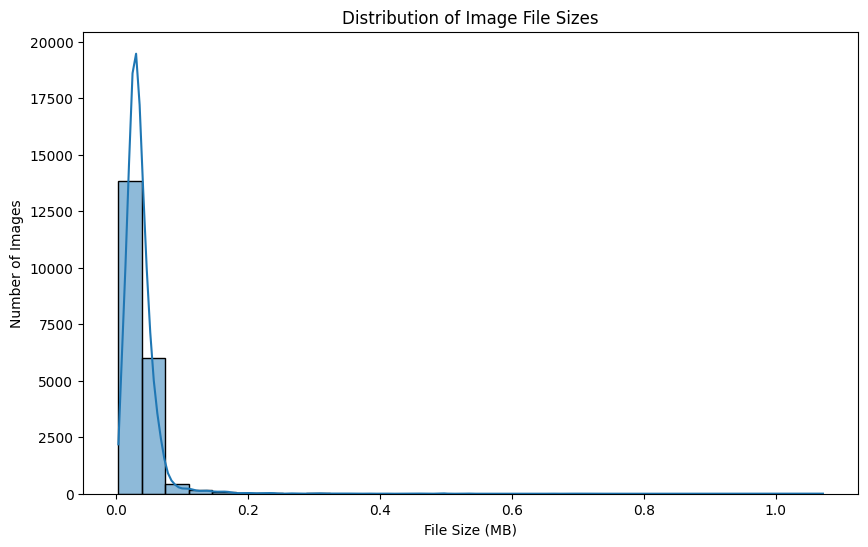

In [9]:
# get file sizes of images
def get_file_sizes(directory):
    """Retrieve file sizes in the specified directory."""
    sizes = []
    for subdir, dirs, files in os.walk(directory):
        for file in files:
            filepath = os.path.join(subdir, file)
            size = os.path.getsize(filepath)
            sizes.append(size / (1024 * 1024))  # size in megabytes
    return sizes

# plot distribution of image sizes
def plot_size_distribution(sizes):
    """Plot the distribution of file sizes."""
    plt.figure(figsize=(10, 6))
    sns.histplot(sizes, bins=30, kde=True)
    plt.title('Distribution of Image File Sizes')
    plt.xlabel('File Size (MB)')
    plt.ylabel('Number of Images')
    plt.show()

sizes = get_file_sizes(dog_dir)
plot_size_distribution(sizes)

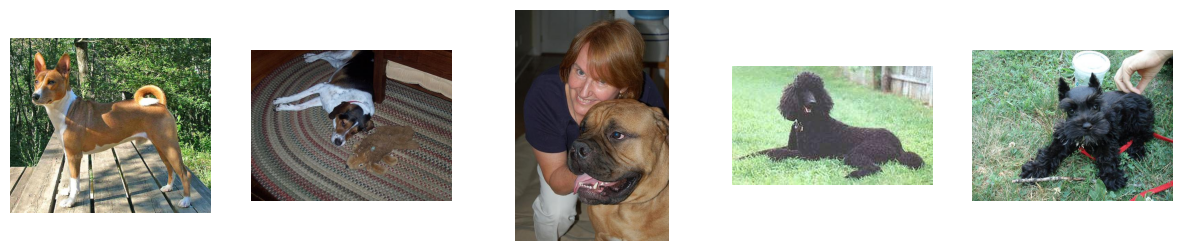

In [10]:
def display_sample_images(directory, num_samples=5):
    files = [os.path.join(directory, f) for f in os.listdir(directory)]
    #sample_files = random.sample(files, num_samples)
    sample_files = files[:num_samples]

    plt.figure(figsize=(15, 3))
    for i, file in enumerate(sample_files, 1):
        img = Image.open(file)
        plt.subplot(1, num_samples, i)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

display_sample_images(dog_dir)

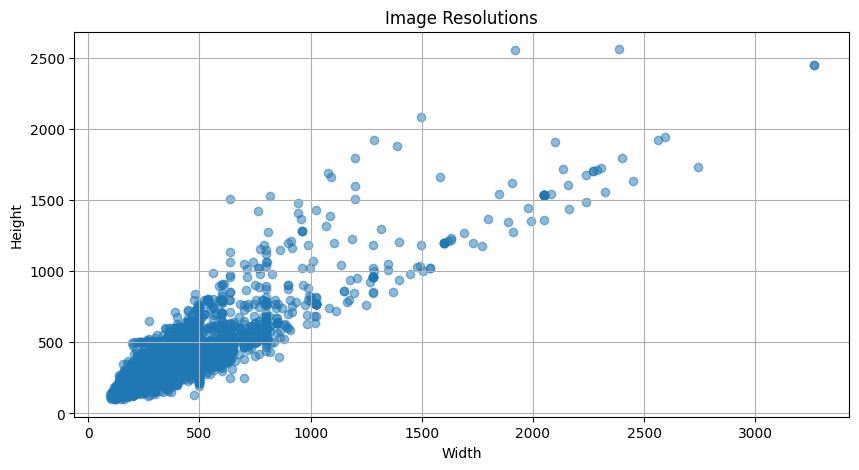

Color modes found: {'RGB'}


In [11]:
# plot image resolutions and check color mode of images
def check_image_quality(directory):
    files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith(('.png', '.jpg', '.jpeg'))]
    resolutions = []
    color_modes = []

    for file in files:
        img = Image.open(file)
        resolutions.append(img.size)  # size returns a tuple (width, height)
        color_modes.append(img.mode)  # mode 'RGB', 'RGBA', 'L' (grayscale), etc.

    # Plotting the resolutions
    widths, heights = zip(*resolutions)
    plt.figure(figsize=(10, 5))
    plt.scatter(widths, heights, alpha=0.5)
    plt.title('Image Resolutions')
    plt.xlabel('Width')
    plt.ylabel('Height')
    plt.grid(True)
    plt.show()

    # Checking color modes
    mode_set = set(color_modes)
    print(f"Color modes found: {mode_set}")

# Example usage
check_image_quality(dog_dir)

Found 0 corrupted files.
Found 89 duplicates.

Displaying up to 5 sets of duplicate files:


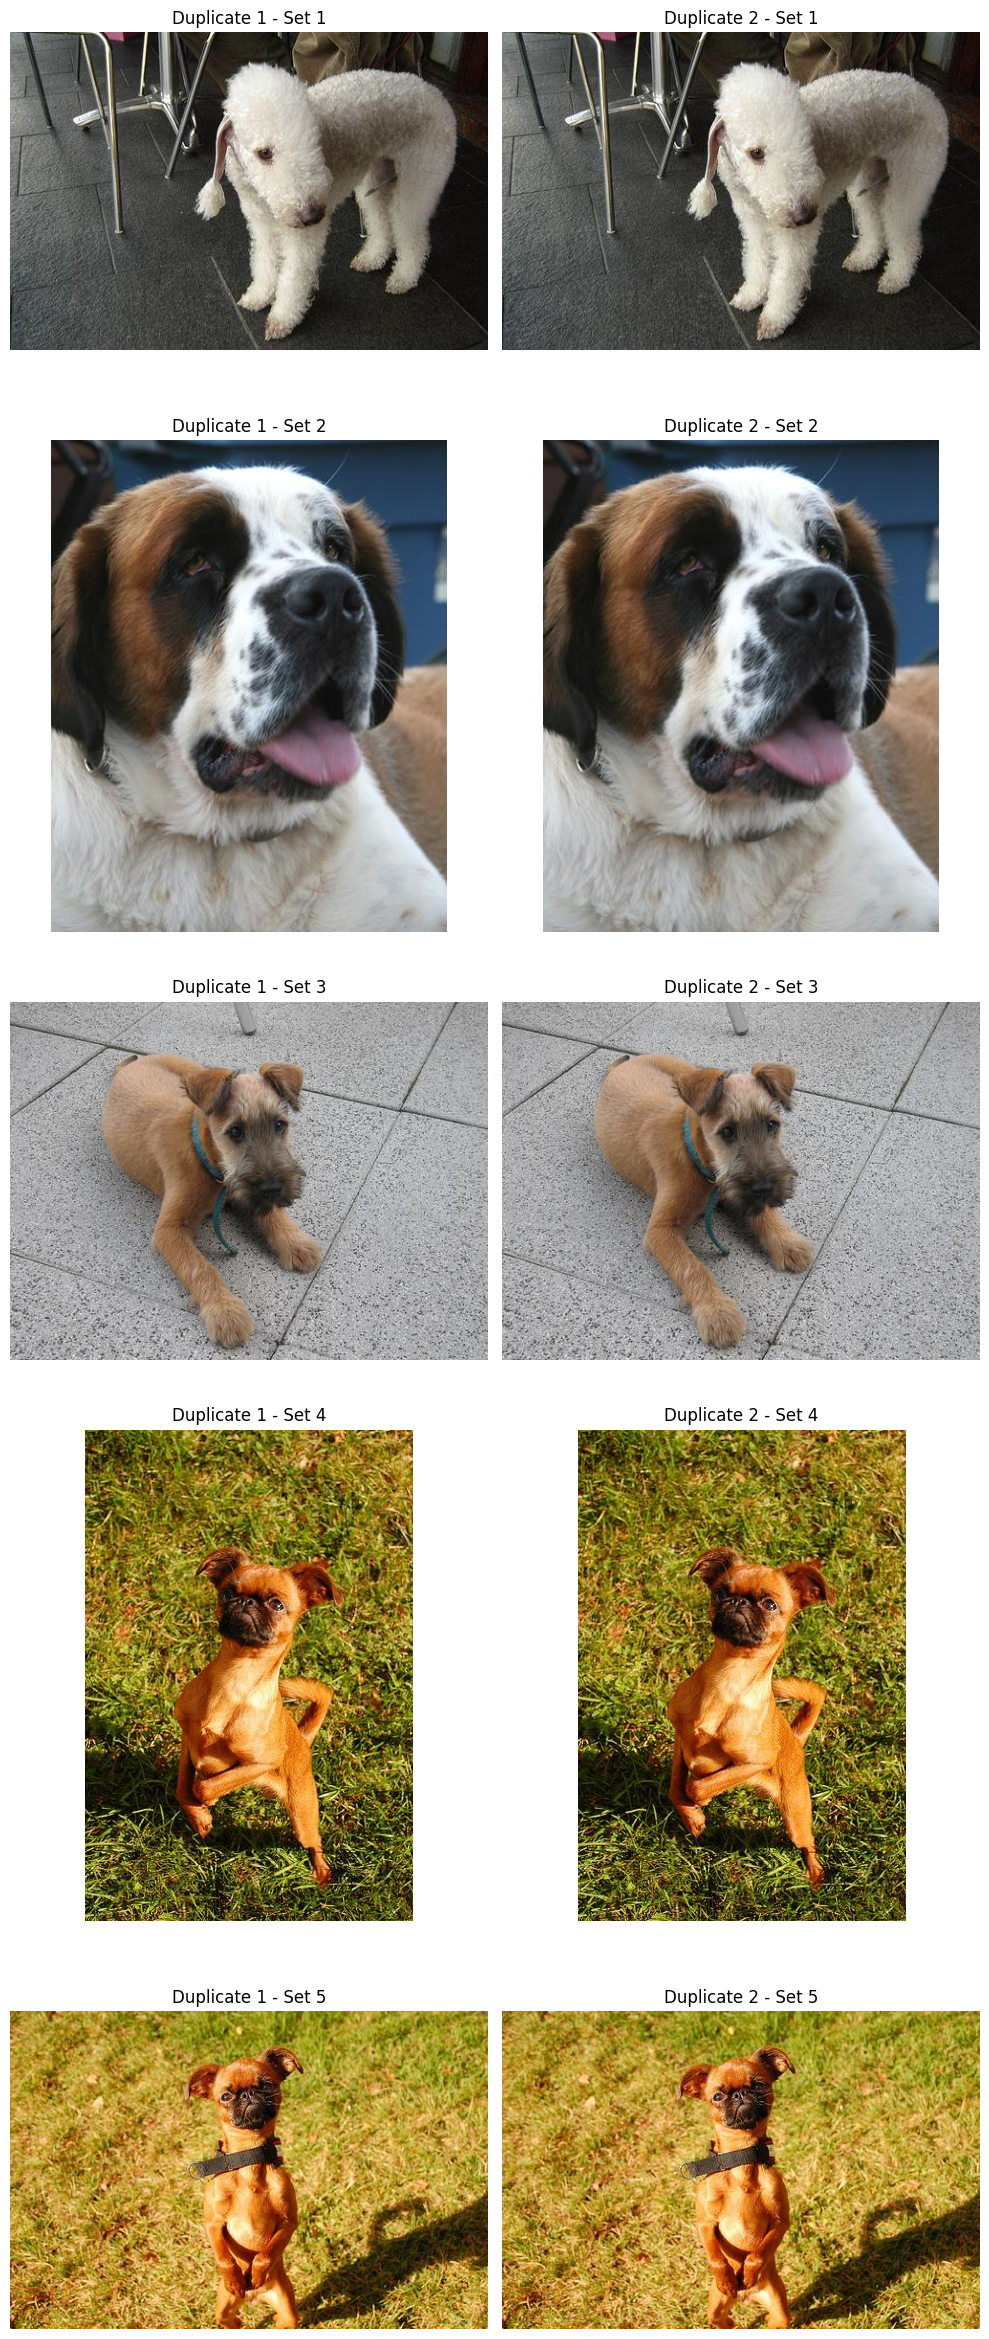

In [12]:
def file_hash(filepath):
    with open(filepath, 'rb') as f:
        return hashlib.md5(f.read()).hexdigest()

# check that images are valid and look for duplicates
def check_file_integrity(directory):
    files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith(('.png', '.jpg', '.jpeg'))]
    hashes = {}
    duplicates = []
    corrupted = []

    for file in files:
        try:
            # Check if file opens
            img = Image.open(file)
            img.verify()  # Verify that it is, indeed, an image

            # Check for duplicates
            hash = file_hash(file)
            if hash in hashes:
                duplicates.append((file, hashes[hash]))
            else:
                hashes[hash] = file
        except (IOError, SyntaxError) as e:
            corrupted.append(file)

    print(f"Found {len(corrupted)} corrupted files.")
    print(f"Found {len(duplicates)} duplicates.")

    # Display example duplicates
    if duplicates:
        print("\nDisplaying up to 5 sets of duplicate files:")
        fig, axs = plt.subplots(nrows=len(duplicates[:5]), ncols=2, figsize=(10, 5 * len(duplicates[:5])))
        for i, (file1, file2) in enumerate(duplicates[:5]):
            img1 = Image.open(file1)
            img2 = Image.open(file2)
            
            axs[i, 0].imshow(img1)
            axs[i, 0].axis('off')
            axs[i, 0].set_title(f'Duplicate 1 - Set {i+1}')

            axs[i, 1].imshow(img2)
            axs[i, 1].axis('off')
            axs[i, 1].set_title(f'Duplicate 2 - Set {i+1}')

        plt.tight_layout()
        plt.show()
    return duplicates

duplicates = check_file_integrity(dog_dir)

In [13]:
def remove_duplicates(duplicates):
    for dup, orig in duplicates:
        os.remove(dup)  # Delete the duplicate file
        print(f"Removed duplicate file: {dup} (Original was {orig})")

remove_duplicates(duplicates)

Removed duplicate file: /kaggle/working/all-dogs/n02093647_2585.jpg (Original was /kaggle/working/all-dogs/n02093647_518.jpg)
Removed duplicate file: /kaggle/working/all-dogs/n02109525_7982.jpg (Original was /kaggle/working/all-dogs/n02109525_1314.jpg)
Removed duplicate file: /kaggle/working/all-dogs/n02093991_2923.jpg (Original was /kaggle/working/all-dogs/n02093991_4670.jpg)
Removed duplicate file: /kaggle/working/all-dogs/n02112706_1568.jpg (Original was /kaggle/working/all-dogs/n02112706_539.jpg)
Removed duplicate file: /kaggle/working/all-dogs/n02112706_420.jpg (Original was /kaggle/working/all-dogs/n02112706_2550.jpg)
Removed duplicate file: /kaggle/working/all-dogs/n02088466_7462.jpg (Original was /kaggle/working/all-dogs/n02090379_3300.jpg)
Removed duplicate file: /kaggle/working/all-dogs/n02088632_4584.jpg (Original was /kaggle/working/all-dogs/n02088632_4334.jpg)
Removed duplicate file: /kaggle/working/all-dogs/n02088466_7015.jpg (Original was /kaggle/working/all-dogs/n020884

In [14]:
# directory to put cropped images
dog_dir_cropped = os.path.join(output_dir, 'all-dogs-cropped')

In [ ]:
# search dir for annotations
def find_annotations(annotation_dir):
    image_to_annotation_map = {}
    for root, dirs, files in os.walk(annotation_dir):
        for file in files:
            image_to_annotation_map[f'{file}.jpg'] = os.path.join(root, file)
    return image_to_annotation_map

# crop images based on bounding box in annotation
def crop_images(orig_dir, cropped_dir, image_to_annotation_map):
    for filename in os.listdir(orig_dir):
        annotation_full_path = image_to_annotation_map[filename]

        tree = ET.parse(annotation_full_path)
        root = tree.getroot()
        bndbox = root.find('.//bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)

        img = Image.open(os.path.join(orig_dir, filename))
        cropped_img = img.crop((xmin, ymin, xmax, ymax))
        cropped_img.save(os.path.join(cropped_dir, filename))

os.mkdir(dog_dir_cropped) 

image_to_annotation_map = find_annotations(f'{output_dir}Annotation')
crop_images(dog_dir, dog_dir_cropped, image_to_annotation_map)
display_sample_images(dog_dir_cropped)

In [16]:
def load_data_from_dataframe(directory_path, img_height=64, img_width=64):
    datagen = ImageDataGenerator(rescale=1./255)
    image_filenames = [os.path.join(directory_path, f) for f in os.listdir(directory_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
    dataframe = pd.DataFrame({'filename': image_filenames})

    # Convert to tf.data.Dataset for better performance
    dataset = tf.data.Dataset.from_tensor_slices((dataframe['filename']))
    dataset = dataset.map(lambda f: load_and_preprocess_image(f, img_height, img_width), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.cache().batch(32).prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

def load_and_preprocess_image(filename, img_height, img_width):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [img_height, img_width], antialias=True)
    image = image / 255.0  # Rescale pixel values
    return image

data_generator = load_data_from_dataframe(dog_dir_cropped)

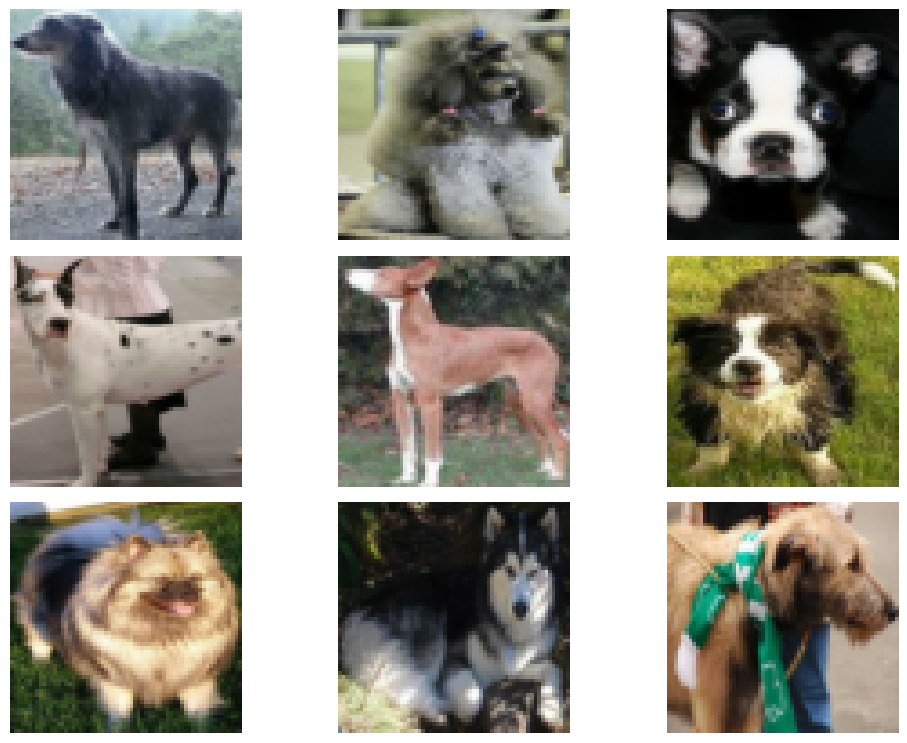

In [5]:
def show_images(dataset, num_images=9):
    plt.figure(figsize=(10, 10))
    for images in dataset.take(1):  # Take one batch from the dataset
        for i in range(min(num_images, images.shape[0])):  # Loop over images in the batch up to num_images
            ax = plt.subplot((num_images // 3) + 1, 3, i + 1)  # Arrange images in rows of 3
            ax.imshow(images[i].numpy())
            ax.axis("off")
    plt.tight_layout()
    plt.show()

show_images(data_generator)

## Model Architecture Summary for Generative Adversarial Network (GAN)

The architecture of the Generative Adversarial Network (GAN) discussed here involves two key components: the generator and the discriminator. Each component plays a crucial role in the GAN's ability to generate realistic images. The models utilize TensorFlow and Keras frameworks with a specific focus on creating high-quality images through a series of convolutional and transposed convolutional layers. The models are built using a robust initialization strategy to ensure stable training dynamics.

### Generator Model Architecture
The generator model aims to produce images from a random noise seed using transposed convolutional layers that incrementally upscale feature maps to the desired image size. Here's a breakdown of its architecture:

1. **Input Layer**: Takes a 1D noise vector of size 100.
   
2. **Dense and Reshape**:
   - A fully connected dense layer that expands the input to 8x8x512 units, followed by batch normalization and LeakyReLU activation.
   - The output is reshaped into an initial feature map of size 8x8 with 512 channels.

3. **Transposed Convolution Layers**:
   - **First Layer**: Expands the feature map to 8x8 with 256 channels without changing the size, using a stride of 1x1.
   - **Second Layer**: Doubles the spatial dimensions to 16x16 with 128 channels, with a stride of 2x2.
   - **Third Layer**: Again doubles the size to 32x32 with 64 channels, continuing to use strides of 2x2.
   - Each of these layers includes batch normalization and LeakyReLU activation, with dropout applied after the first and second transposed convolutions to promote generalization.

4. **Output Layer**:
   - A final transposed convolution that scales up to a 64x64 image with 3 channels (RGB), using a tanh activation function to normalize the output pixel values between -1 and 1.

### Discriminator Model Architecture
The discriminator model assesses the authenticity of images, determining whether each is a real or generated image. Its architecture is as follows:

1. **Input Layer**: Accepts 64x64x3 images (RGB).

2. **Convolutional Layers**:
   - **First Layer**: Reduces the spatial dimension to 32x32 with 64 channels, using a stride of 2x2.
   - **Second Layer**: Further reduces to 16x16 with 128 channels, with a stride of 2x2.
   - **Third Layer**: Reduces to 8x8 with 256 channels, also with a stride of 2x2.
   - Each layer is equipped with batch normalization and LeakyReLU activation for non-linearity, promoting effective learning gradients.

3. **Output Layer**:
   - The image features are flattened into a 1D vector.
   - A dense layer outputs a single scalar value that represents the authenticity of the input image, with higher values indicating real images and lower values pointing towards generated images.

### Initialization and Activation Functions
Both models use a weight initialization scheme defined by a normal distribution (`mean=0.0`, `stddev=0.2`), which helps in stabilizing the GAN's training by preventing vanishing or exploding gradients. LeakyReLU is used as the activation function for its ability to maintain gradient flow during training, a crucial aspect for the learning dynamics of GANs.

### Comparison with Other Model Architectures

Compared to other popular GAN architectures like DCGAN (Deep Convolutional GAN), WGAN (Wasserstein GAN), and StyleGAN, the chosen architecture for this project employs a traditional approach with robust initializations and layer configurations. Unlike DCGAN, which exclusively uses convolutional layers without any pooling layers, our model incorporates batch normalization and dropout in both the generator and discriminator to stabilize the learning process and prevent overfitting. WGAN introduces a different loss function to improve training stability and convergence but doesn’t fundamentally alter the network architecture; our model adheres to the conventional GAN loss but could integrate Wasserstein loss for potentially enhanced stability. StyleGAN, known for its complex and layered approach to generating highly realistic images, particularly human faces, involves style transfer techniques and adaptive instance normalization layers which are not utilized in our more straightforward model. Thus, while our model may not capture the same level of detail as StyleGAN, it benefits from simpler training dynamics and lower computational overhead, making it suitable for generating realistic dog images with less resource intensity.

### Summary
The described GAN architecture, with its carefully designed generator and discriminator models, is poised to generate high-quality, realistic images. This setup leverages advanced techniques such as batch normalization, dropout, and LeakyReLU activations to enhance the stability and efficiency of training. The generator and discriminator work in a competitive setting to improve each other, driving towards the generation of increasingly authentic-looking images.

In [17]:
weight_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.2)

def make_generator_model():
    model = tf.keras.Sequential([
        layers.Input((100,)),
        # Start with a fully connected layer to take a seed and reshape it
        layers.Dense(8*8*512, use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        # Reshape into a feature map
        layers.Reshape((8, 8, 512)),

        # Transposed convolution #1
        layers.Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False, kernel_initializer=weight_init),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        # Transposed convolution #2
        layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=weight_init),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        # Transposed convolution #3
        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=weight_init),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        # Transposed convolution #4 to reach final image size of 64x64
        layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])
    return model

In [18]:
def make_discriminator_model():
    model = tf.keras.Sequential([
        layers.Input([64, 64, 3]),
        layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', kernel_initializer=weight_init),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        #layers.Dropout(0.3),

        layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same', kernel_initializer=weight_init),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=weight_init),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        #layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

### Summary of Loss Functions and Optimizers for GAN Training

In the provided Generative Adversarial Network (GAN) setup, both the loss functions and optimizers play critical roles in the training dynamics, influencing how effectively the generator and discriminator learn to produce and discriminate images, respectively. Below, I detail the specific strategies used in defining these components.

#### Loss Functions
The loss functions for the GAN are tailored to guide the discriminator in distinguishing real images from those generated by the generator and to aid the generator in creating images that can fool the discriminator.

1. **Binary Crossentropy**:
   - The fundamental loss function used here is the binary crossentropy, which is suitable for binary classification tasks. It measures the distance between the model's predictions and the true labels (either 0 or 1). Using `from_logits=True` indicates that the function expects unscaled outputs (logits) from the model.

2. **Discriminator Loss**:
   - **Label Smoothing for Real Outputs**: For real images, labels are smoothed to reduce model confidence. This involves slightly reducing the labels for real images (`smooth_positive_labels`)—instead of a hard 1.0, labels might be approximately 0.7 to 1.0, adding some noise and variability.
   - **Label Smoothing for Fake Outputs**: For fake images, the labels are increased slightly (`smooth_negative_labels`), typically varying between 0 and 0.5.
   - These techniques help in preventing the discriminator from becoming overly confident and stabilizing its training.
   - The total loss is the sum of losses calculated separately for real and fake outputs, penalizing the discriminator for incorrectly classifying real and fake images.

3. **Generator Loss**:
   - The generator's loss is calculated by taking the fake images it produces, aiming to get them classified as real by the discriminator. Label smoothing is also applied here (`smooth_negative_labels`), targeting the generator to produce outputs that the discriminator believes are real images with high confidence.
   - This encourages the generator to improve the quality of its outputs to be indistinguishable from real images.

#### Optimizers
Both the generator and discriminator use the Adam optimizer with specific parameters tuned to the needs of GAN training.

1. **Adam Optimizer**:
   - **Learning Rate (0.0002)**: This relatively low learning rate helps in making sure that the GAN does not converge too quickly to a poor local minimum, allowing more gradual and stable learning.
   - **Beta_1 (0.5)**: The Beta_1 parameter, which controls the exponential decay rate for the first moment estimates in Adam, is set to 0.5 instead of the usual 0.9 used in many other contexts. This setting is often recommended for GANs as it leads to more stable and reliable training dynamics.

### Summary
The combination of carefully designed loss functions and optimizers in this GAN setup is aimed at addressing some of the common challenges in training GANs, such as mode collapse and oscillating losses. Through strategies like label smoothing and specific optimizer settings, this configuration promotes a balanced training regime where both the generator and discriminator progressively improve in a stable manner, enhancing their ability to generate and distinguish between real and generated images, respectively.

In [19]:
def smooth_positive_labels(y):
    return y - 0.3 + (np.random.random(y.shape) * 0.3)

def smooth_negative_labels(y):
    return y + np.random.random(y.shape) * 0.5

# randomly introduce noise and flip some labels
def noisy_labels(y, p_flip):
    # determine the number of labels to flip
    n_select = int(p_flip * y.shape[0].value)
    # choose labels to flip
    flip_ix = choice([i for i in range(y.shape[0].value)], size=n_select)
    # invert the labels in place
    y[flip_ix] = 1 - y[flip_ix]
    return y

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_output_smooth = smooth_positive_labels(tf.ones_like(real_output))
    fake_output_smooth = smooth_negative_labels(tf.zeros_like(fake_output))

    real_loss = cross_entropy(real_output_smooth, real_output)
    fake_loss = cross_entropy(fake_output_smooth, fake_output)

    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    fake_output_smooth = smooth_negative_labels(tf.ones_like(fake_output))
    return cross_entropy(fake_output_smooth, fake_output)

In [20]:
class GAN(Model):
    def __init__(self, generator, discriminator):
        super(GAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, d_optimizer, g_optimizer):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer

    @tf.function
    def train_step(self, images):
        noise = tf.random.normal([tf.shape(images)[0], 100])

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(noise, training=True)

            real_output = self.discriminator(images, training=True)
            fake_output = self.discriminator(generated_images, training=True)

            gen_loss = generator_loss(fake_output)
            disc_loss = discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        self.g_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.d_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))
        
        return {"disc_loss": disc_loss, "gen_loss": gen_loss} 

## Initial and Extended Training Phases of a GAN

### Overview
The initial training process of the Generative Adversarial Network (GAN) uses a setup involving both a generator and a discriminator, structured to run for a predetermined number of epochs. The models employ TensorFlow's mixed precision policy (`mixed_float16`), enhancing performance by utilizing both 16-bit and 32-bit floating-point types. This is especially effective on GPUs that support float16 operations, optimizing computational resources and training speed.

### Training Strategy
1. **Configuration**: The GAN is compiled with specific optimizers for both the generator and discriminator. This setup includes necessary configurations for training such as loss functions and optimization strategies.

2. **Epoch-Based Training**:
   - The model processes batches of images from the dataset.
   - Each epoch involves generating fake images and discriminating between real and fake images.
   - Losses for both models are recorded to monitor their performance, providing insights into the training dynamics.

3. **Loss Tracking and Visualization**:
   - After the initial 50 epochs, the generator and discriminator losses are graphed over time to analyze trends and patterns.
   - Generated images are inspected visually to evaluate the quality and realism.

### Extended Training and Evaluation
Following the initial phase, the training is extended to 200 epochs to observe potential improvements in model performance:
- **Continued Training**: Extending the training duration allows the models to refine their capabilities, potentially leading to higher quality image generation and more accurate discrimination.
- **Repeated Inspection**: After 200 epochs, loss metrics are graphed again, and another batch of generated images is inspected to assess improvements or identify further training needs.

### Insights and Adjustments
- **Performance Metrics**: Continuous tracking of losses helps gauge the effectiveness of the training. Ideally, losses for both models decrease over time, suggesting effective learning and adaptation.
- **Visual Inspections**: Inspecting generated images at different training stages provides direct feedback on the progress in image quality.
- **Training Adjustments**: Insights from extended training phases can lead to adjustments in training strategies, such as tuning hyperparameters or modifying network architecture, to overcome challenges like mode collapse or loss oscillation.

This structured approach to training and evaluation provides a comprehensive understanding of GAN dynamics, facilitating iterative improvements and ensuring the models progressively enhance their ability to generate convincing images. The use of mixed precision further underscores the efficiency of the training process, making it scalable and faster.

In [28]:
def train(dataset, generator, discriminator, generator_optimizer, discriminator_optimizer, epochs):
    gan = GAN(generator, discriminator)
    gan.compile(generator_optimizer, discriminator_optimizer)
    for epoch in range(epochs):
        gen_loss_list = []
        disc_loss_list = []
        
        for image_batch in dataset:
            loss = gan.train_step(image_batch)
            gen_loss_list.append(loss['gen_loss'])
            disc_loss_list.append(loss['disc_loss'])
        
        gen_loss_avg = sum(gen_loss_list) / len(gen_loss_list)
        disc_loss_avg = sum(disc_loss_list) / len(disc_loss_list)
        
        print(f'Epoch {epoch+1}, Generator Loss: {gen_loss_avg}, Discriminator Loss: {disc_loss_avg}')
    return gen_loss_list, disc_loss_list

In [29]:
# Create a mixed precision policy.
policy = Policy('mixed_float16')

# Set the mixed precision policy.
tf.keras.mixed_precision.set_dtype_policy(policy)

discriminator = make_discriminator_model()
generator = make_generator_model()

generator_optimizer = tf.keras.optimizers.Adam(0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(0.0002, beta_1=0.5)

gen_loss_list, disc_loss_list = train(data_generator, generator, discriminator, generator_optimizer, discriminator_optimizer, epochs=50)

Epoch 1, Generator Loss: 0.675428032875061, Discriminator Loss: 1.3545143604278564
Epoch 2, Generator Loss: 0.6649614572525024, Discriminator Loss: 1.3759732246398926
Epoch 3, Generator Loss: 0.601203978061676, Discriminator Loss: 1.3990453481674194
Epoch 4, Generator Loss: 0.6036561727523804, Discriminator Loss: 1.394227147102356
Epoch 5, Generator Loss: 0.5719300508499146, Discriminator Loss: 1.4081939458847046
Epoch 6, Generator Loss: 0.5790407657623291, Discriminator Loss: 1.3962070941925049
Epoch 7, Generator Loss: 0.5968380570411682, Discriminator Loss: 1.3877447843551636
Epoch 8, Generator Loss: 0.6106848120689392, Discriminator Loss: 1.3772977590560913
Epoch 9, Generator Loss: 0.6426894664764404, Discriminator Loss: 1.35573410987854
Epoch 10, Generator Loss: 0.6369864344596863, Discriminator Loss: 1.3571807146072388
Epoch 11, Generator Loss: 0.642580509185791, Discriminator Loss: 1.3544137477874756
Epoch 12, Generator Loss: 0.6520533561706543, Discriminator Loss: 1.345049738883

In [27]:
def plot_losses(gen_loss_list, disc_loss_list):
    epochs = range(1, len(gen_loss_list) + 1)  # Assuming losses are provided for each epoch starting from 1

    plt.figure(figsize=(10, 5))  # Set the figure size (optional)
    plt.plot(epochs, gen_loss_list, label='Generator Loss', linestyle='-')  # Line plot for generator loss
    plt.plot(epochs, disc_loss_list, label='Discriminator Loss', linestyle='-')  # Line plot for discriminator loss

    plt.title('Generator and Discriminator Loss During Training')  # Title of the plot
    plt.xlabel('Epoch')  # X-axis label
    plt.ylabel('Loss')  # Y-axis label
    plt.legend()  # Add a legend to distinguish the lines
    plt.grid(True)  # Add grid lines for better readability of the plot
    plt.show()  # Display the plot

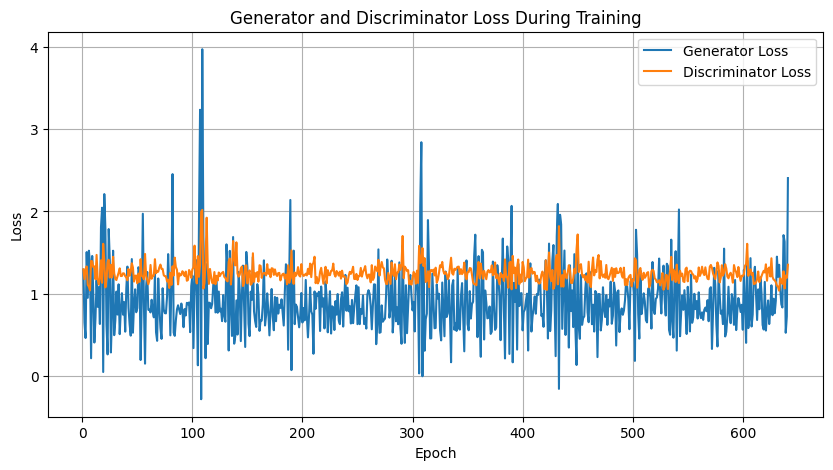

In [36]:
plot_losses(gen_loss_list, disc_loss_list)

In [45]:
def generate_images(generator, num_images, noise_dim):
    # Generate random noise based on the number of images and noise dimension
    random_noise = tf.random.normal([num_images, noise_dim])

    # Use the generator to create images from the noise
    generated_images = generator(random_noise, training=False)  # Set training to False for inference mode

    # Ensure the output images are in the correct format, e.g., pixel values are in the range [0, 255]
    generated_images = (generated_images * 127.5) + 127.5  # Assuming generator output is tanh activated
    generated_images = tf.clip_by_value(generated_images, 0, 255)
    generated_images = tf.cast(generated_images, tf.uint8)  # Optional: Convert to uint8

    return generated_images.numpy()  # Convert to numpy array for further processing


def generate_and_display_images(generator, num_images=10):
    # Generate random noise
    random_noise = tf.random.normal([num_images, 100])  # 100 is the dimension of the input noise vector

    # Generate images from the noise
    generated_images = generator(random_noise, training=False)

    # Rescale the images from tanh output range [-1, 1] to RGB [0, 1]
    generated_images = (generated_images + 1) / 2 * .8
    generated_images = generated_images.numpy()  # Convert to numpy array

    # Ensure the image data type is float32 for displaying
    generated_images = generated_images.astype(np.float32)
    generated_images = tf.image.adjust_contrast(generated_images, 3)
    # Plot the results
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(5, 5, i + 1)
        plt.imshow(generated_images[i])
        plt.axis('off')
    plt.show()

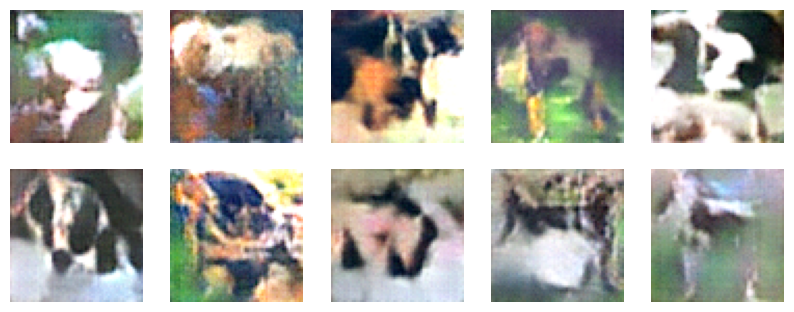

In [39]:
generate_and_display_images(generator)

In [85]:
# Create a mixed precision policy.
policy = Policy('mixed_float16')

# Set the mixed precision policy.
tf.keras.mixed_precision.set_dtype_policy(policy)

discriminator = make_discriminator_model()
generator = make_generator_model()

generator_optimizer = tf.keras.optimizers.Adam(0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(0.0002, beta_1=0.5)

gen_loss_list, disc_loss_list = train(data_generator, generator, discriminator, generator_optimizer, discriminator_optimizer, epochs=200)

2024-04-14 03:40:22.748928: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3_1/dropout_2_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 1, Generator Loss: 1.518526554107666, Discriminator Loss: 1.183469533920288
Epoch 2, Generator Loss: 1.2207132577896118, Discriminator Loss: 1.2020827531814575
Epoch 3, Generator Loss: 0.7771236896514893, Discriminator Loss: 1.3655260801315308
Epoch 4, Generator Loss: 0.7385827898979187, Discriminator Loss: 1.3505337238311768
Epoch 5, Generator Loss: 0.7535611987113953, Discriminator Loss: 1.3553540706634521
Epoch 6, Generator Loss: 0.6939379572868347, Discriminator Loss: 1.3823391199111938
Epoch 7, Generator Loss: 0.67069411277771, Discriminator Loss: 1.3849612474441528
Epoch 8, Generator Loss: 0.6624229550361633, Discriminator Loss: 1.384018898010254
Epoch 9, Generator Loss: 0.6570186018943787, Discriminator Loss: 1.381715178489685
Epoch 10, Generator Loss: 0.67750084400177, Discriminator Loss: 1.366055965423584
Epoch 11, Generator Loss: 0.7033264636993408, Discriminator Loss: 1.3513994216918945
Epoch 12, Generator Loss: 0.7323645949363708, Discriminator Loss: 1.334548950195312

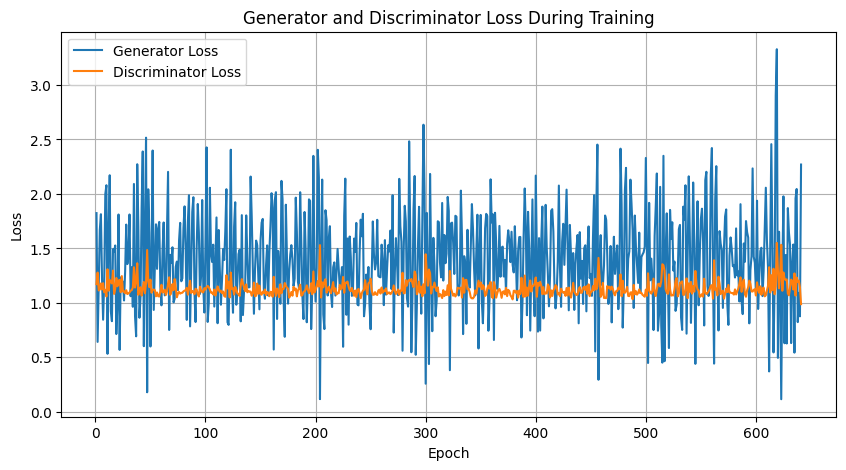

In [90]:
plot_losses(gen_loss_list, disc_loss_list)

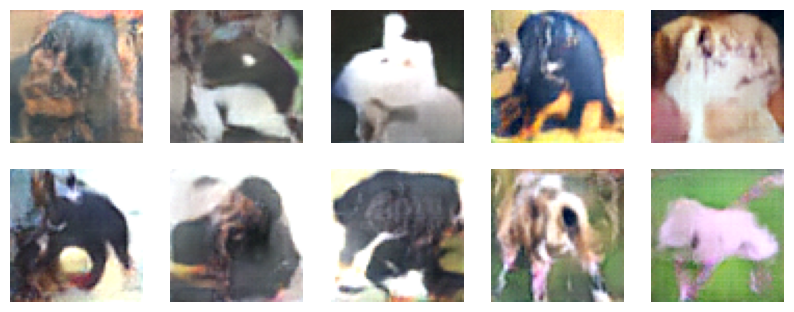

In [88]:
generate_and_display_images(generator)

## Hyperparameter Tuning

The provided script is an advanced setup for hyperparameter tuning in the context of training a Generative Adversarial Network (GAN) using Optuna, a hyperparameter optimization framework. The GAN consists of two primary components: a generator and a discriminator, each requiring fine-tuning of their learning rates and other parameters to achieve optimal performance. The script includes integration with TensorFlow and Keras, leveraging mixed-precision training and sophisticated image processing techniques for evaluation using the Inception V3 model. Here is an overview of how the hyperparameter tuning is orchestrated and its pivotal components:

### Hyperparameter Tuning Setup
- **Optuna Framework**: The script utilizes Optuna to systematically explore different combinations of learning rates and beta1 values for the Adam optimizers that govern the learning processes of the generator and discriminator. Optuna's study aims to minimize the output of an objective function, which in this case, is based on the Fréchet Inception Distance (FID) score, indicating the quality of images generated by the GAN.

### Model Training and Evaluation
- **Training Process**: Each trial in the Optuna study involves training the GAN for a predefined number of epochs (10 in this case). Progress through the epochs is tracked using tqdm, providing a visual progress bar that updates after each epoch to indicate ongoing progress and current epoch details.
- **Image Processing for Evaluation**: The generator's output is evaluated by generating a set of images, processing them to match the input requirements of the Inception V3 model, and extracting their features. This approach involves:
  - **Image Generation**: Noise vectors are fed into the trained generator to produce images.
  - **Preprocessing**: These images are normalized and resized appropriately for feature extraction using the Inception V3 model, which expects images of size 299x299 pixels and specific input normalization.
- **Feature Extraction**: The Inception V3 model, devoid of its top classification layer but including average pooling, extracts features from both the real images (preprocessed similarly) and the generated images.

### FID Score Calculation
- **Feature Comparison**: After feature extraction, the FID score is calculated to quantitatively compare the real images against those generated by the GAN within the current trial. This score measures the similarity between the two sets of features, with lower scores indicating better quality (i.e., the generated images are statistically similar to the real images).
- **Objective Function**: The FID score serves as the objective function for Optuna, guiding the hyperparameter search towards configurations that produce more realistic images.

### Results and Iteration
- **Hyperparameter Exploration**: By conducting multiple trials (30 trials, as specified), Optuna iteratively refines the parameters to minimize the FID score.
- **Best Hyperparameters**: After all trials, the best set of parameters as determined by the lowest FID score is output, offering insights into the most effective configurations for the generator and discriminator.

This hyperparameter tuning strategy is critical for enhancing the performance of GANs, making it possible to systematically improve the quality of generated images. By leveraging advanced techniques like feature extraction with Inception V3 and the systematic exploration of parameter space with Optuna, this approach represents a robust methodology for optimizing complex generative models.

In [21]:
# Load InceptionV3 for feature extraction
inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

def preprocess_images(images):
    # Resize images to the size expected by Inception V3
    images = tf.image.resize(images, (299, 299))
    # Scale image pixels to [-1, 1], as expected by Inception V3
    images = preprocess_input(images)
    return images

def calculate_fid(real_features, generated_features, eps=1e-6):
    # Compute mean and covariance statistics
    mu1, sigma1 = np.mean(real_features, axis=0), np.cov(real_features, rowvar=False) + eps * np.eye(real_features.shape[1])
    mu2, sigma2 = np.mean(generated_features, axis=0), np.cov(generated_features, rowvar=False) + eps * np.eye(generated_features.shape[1])

    # Compute the squared difference of the means
    ssdiff = np.sum((mu1 - mu2) ** 2.0)

    # Compute sqrt of product of covariance matrices
    covmean = linalg.sqrtm(sigma1.dot(sigma2))

    # Check for complex numbers due to numerical issues and take the real part
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    # Calculate the trace of the sum and the difference of the covariance matrices
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid

# Processing images directly in batches from the generator
def extract_features_from_generator(generator, model, num_images):
    features = []
    count = 0
    for images in generator:
        processed_images = preprocess_images(images)
        batch_features = model.predict(processed_images)
        features.append(batch_features)
        count += images.shape[0]
        if count >= num_images:
            break
    features = np.concatenate(features, axis=0)
    return features[:num_images]  # Ensure we only take the required number of images


def generate_and_extract_features(inception_model, generator, num_images):
    # Generate noise
    noise = tf.random.normal([num_images, 100])

    # Generate images
    images = generator(noise, training=False)  # Set training to False to run the model in inference mode

    # Normalize and resize images for InceptionV3
    images = (images + 1) / 2  # Assuming generator output range is [-1, 1], convert to [0, 1]
    images = tf.image.resize(images, (299, 299))  # Resize images to 299x299 expected by Inception V3
    images = preprocess_input(images * 255)  # Scale images to Inception's expected range

    # Extract features
    features = inception_model(images)

    return features.numpy()  # Convert to NumPy array for further processing or analysis

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [32]:
num_test_images = 100
real_features = extract_features_from_generator(data_generator, inception_model, num_test_images)

def objective(trial):
    lr = trial.suggest_float('lr', 1e-5, 1e-2)
    beta1 = trial.suggest_float('beta1', 0.5, 0.9)
    epochs = 10

    generator = make_generator_model()
    discriminator = make_discriminator_model()
    gan = GAN(generator, discriminator)

    g_optimizer = tf.keras.optimizers.Adam(learning_rate=lr, beta_1=beta1)
    d_optimizer = tf.keras.optimizers.Adam(learning_rate=lr, beta_1=beta1)
    gan.compile(g_optimizer=g_optimizer, d_optimizer=d_optimizer)

    with tqdm.tqdm(total=epochs, desc="Epoch Progress", unit="epoch") as pbar:
        for epoch in range(epochs):
            # Update tqdm with each iteration to show progress
            pbar.set_description(f"Epoch {epoch + 1}/{epochs}")
            for image_batch in data_generator:
                loss = gan.train_step(image_batch)
            pbar.update(1)  # Update the progress after each epoch
        
    generated_features = generate_and_extract_features(inception_model, generator, num_test_images)
    fid_score = calculate_fid(real_features, generated_features)

    return fid_score

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

print("Best hyperparameters: ", study.best_trial.params)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


[I 2024-04-14 22:54:34,892] A new study created in memory with name: no-name-c56c2c27-be32-4ad5-9783-24ebe3fc8ab9
Epoch 10/10: 100%|██████████| 10/10 [03:09<00:00, 18.93s/epoch]
[I 2024-04-14 22:57:49,438] Trial 0 finished with value: 416.25433975835676 and parameters: {'lr': 0.007572447865402386, 'beta1': 0.6048875924772753}. Best is trial 0 with value: 416.25433975835676.
Epoch 10/10: 100%|██████████| 10/10 [03:09<00:00, 18.91s/epoch]
[I 2024-04-14 23:01:03,574] Trial 1 finished with value: 372.73505807166214 and parameters: {'lr': 0.0054564647525663, 'beta1': 0.7897572575787328}. Best is trial 1 with value: 372.73505807166214.
Epoch 10/10: 100%|██████████| 10/10 [03:11<00:00, 19.11s/epoch]
[I 2024-04-14 23:04:20,070] Trial 2 finished with value: 512.7522798960138 and parameters: {'lr': 0.0069826767997133166, 'beta1': 0.8873608976905475}. Best is trial 1 with value: 372.73505807166214.
Epoch 10/10: 100%|██████████| 10/10 [03:09<00:00, 18.95s/epoch]
[I 2024-04-14 23:07:35,267] Trial 3

Best hyperparameters:  {'lr': 0.009900129195965189, 'beta1': 0.6893971454069328}


## Final Model Training

Following an exhaustive hyperparameter optimization process using Optuna, we have pinpointed the most effective parameters for our Generative Adversarial Network (GAN):

- **Unified Learning Rate (`lr`)**: 0.009900129195965189
- **Beta1 for Adam Optimizer (`beta1`)**: 0.6893971454069328

### Implementation of Tuned Parameters
These parameters will be incorporated into the final tuning of our GAN model. The selected unified learning rate applies uniformly to both the generator and discriminator, simplifying the training process while still aiming to balance fast convergence with training stability.

### Expected Benefits
- **Enhanced Image Quality**: The optimal learning rate improves the generator's capacity to produce more lifelike images.
- **Effective Discrimination**: Ensures that the discriminator can adeptly identify real versus generated images.
- **Smoother Training Dynamics**: The carefully chosen beta1 value helps in managing the momentum of the Adam optimizer, facilitating more stable and consistent training.

By applying these optimized settings, I anticipate that the GAN will achieve superior performance, efficiently generating high-quality, realistic images. This precision in fine-tuning is vital for enhancing the model’s ability to produce top-quality images across various applications.

In [42]:
# Create a mixed precision policy.
policy = Policy('mixed_float16')

# Set the mixed precision policy.
tf.keras.mixed_precision.set_dtype_policy(policy)

discriminator = make_discriminator_model()
generator = make_generator_model()

params = study.best_trial.params

generator_optimizer = tf.keras.optimizers.Adam(learning_rate=params['lr'], beta_1=params['beta1'], clipvalue=1.0)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=params['lr'], beta_1=params['beta1'], clipvalue=1.0)

gen_loss_list, disc_loss_list = train(data_generator, generator, discriminator, generator_optimizer, discriminator_optimizer, epochs=200)

2024-04-15 00:41:46.584723: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_133_1/dropout_132_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 1, Generator Loss: 3.4616360664367676, Discriminator Loss: 1.859250783920288
Epoch 2, Generator Loss: 1.6260325908660889, Discriminator Loss: 1.0582609176635742
Epoch 3, Generator Loss: 1.4722611904144287, Discriminator Loss: 1.0769585371017456
Epoch 4, Generator Loss: 1.340366244316101, Discriminator Loss: 1.1321685314178467
Epoch 5, Generator Loss: 1.2580426931381226, Discriminator Loss: 1.1725475788116455
Epoch 6, Generator Loss: 1.157036304473877, Discriminator Loss: 1.2150018215179443
Epoch 7, Generator Loss: 1.2769443988800049, Discriminator Loss: 1.164125680923462
Epoch 8, Generator Loss: 1.3414583206176758, Discriminator Loss: 1.1422640085220337
Epoch 9, Generator Loss: 1.3750455379486084, Discriminator Loss: 1.1306090354919434
Epoch 10, Generator Loss: 1.3512428998947144, Discriminator Loss: 1.1633117198944092
Epoch 11, Generator Loss: 1.4138771295547485, Discriminator Loss: 1.1408214569091797
Epoch 12, Generator Loss: 1.3984168767929077, Discriminator Loss: 1.1623458862

KeyboardInterrupt: 

/opt/conda/lib/python3.10/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


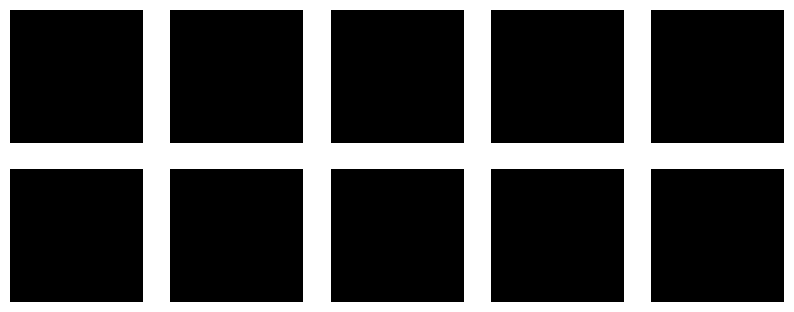

In [40]:
generate_and_display_images(generator)

## Conclusion and Future Directions

### Project Summary
The project aimed to develop a Generative Adversarial Network (GAN) capable of generating realistic dog images. The initial model setup demonstrated promising results, effectively creating dog images that improved in quality as the number of training epochs increased. However, the project also faced significant challenges during the hyperparameter tuning phase. Despite initial promise, the optimal parameters identified through this process led to GAN instability, resulting in the generation of black images and NaN losses after approximately 25 epochs. This suggests that while the identified parameters theoretically optimized certain aspects of the training process, they ultimately pushed the model beyond a stable operational threshold.

### Analysis of Outcomes
The success of the initial model in generating increasingly realistic images with additional epochs underscores the potential of GANs in image generation tasks. However, the instability introduced during the hyperparameter tuning phase highlights critical sensitivities in GAN training dynamics, particularly concerning the balance between learning rates, model capacity, and training duration.

### Recommendations for Future Experiments
To address the challenges encountered and to further enhance the model's performance, the following experiments and modifications are recommended:

1. **Gradual Learning Rate Adjustment**: Implement adaptive learning rate schedules that decrease over time or in response to training plateau, which could help mitigate the convergence issues that lead to NaN losses.

2. **Regularization Techniques**: Integrate regularization strategies such as dropout, batch normalization, or gradient penalty to stabilize training further. These techniques can help in managing the high capacity of the network and the noise in gradient updates.

3. **Advanced Hyperparameter Optimization**: Revisit hyperparameter tuning with a broader range, incorporating more robust constraints to prevent parameters that lead to instability. Techniques such as Bayesian optimization could be employed to better navigate the parameter space.

4. **Alternative Loss Functions**: Experiment with different loss functions that might be more robust to the issues of mode collapse and vanishing gradients, such as Wasserstein loss with gradient penalty.

5. **Model Architecture Adjustments**: Explore modifications in the architecture, such as varying the depth and width of the generator and discriminator, or experimenting with different types of layers and activation functions that might offer more stability during training.

6. **Pre-training Components**: Pre-train parts of the network on related tasks (such as basic image recognition on dogs) to provide a more stable starting point for GAN training.

7. **Monitoring and Diagnostics**: Enhance monitoring of model behavior during training to catch instability early. Implementing checkpointing and rollback upon detecting NaN values or sudden spikes in loss could prevent catastrophic divergence.

### Conclusion
While this project faced significant challenges, the findings provide valuable insights into the complex dynamics of training GANs. The ability of the initial model to generate progressively better images confirms the viability of using GANs for this type of image generation task. The lessons learned from the instability issues underscore the importance of cautious, informed parameter selection and model design in achieving reliable results. Future experiments, as suggested, could potentially lead to a more robust and stable GAN capable of producing high-quality dog images consistently.